In [8]:
import sys
import subprocess
import importlib.util

required = ["pandas", "openpyxl", "scikit-learn", "numpy", "seaborn", "matplotlib"]
missing = [pkg for pkg in required if importlib.util.find_spec(pkg) is None]

if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages already installed.")



Installing missing packages: ['scikit-learn']


In [9]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

DATA_PATH = "dataset.xlsx"

# Load and clean
raw = pd.read_excel(DATA_PATH)
raw.columns = raw.columns.str.strip()

if "Patient ID" not in raw.columns:
    raise KeyError("'Patient ID' column is required for deduplication.")

# Drop duplicate patients
clean = raw.drop_duplicates(subset=["Patient ID"]).copy()
feature_cols = [c for c in clean.columns if c != "Patient ID"]

# Patient filter: keep rows with at least 10 non-missing labs
patient_counts = clean[feature_cols].notna().sum(axis=1)
patient_filtered = clean[patient_counts >= 10].copy()

# Feature filter: keep features with <80% missingness in this subset
missing_frac = patient_filtered[feature_cols].isna().mean()
kept_features = missing_frac[missing_frac < 0.80].index.tolist()
final_cols = ["Patient ID"] + kept_features

filtered = patient_filtered[final_cols].copy()

print(f"Patients retained (>=10 labs): {filtered.shape[0]}")
print(f"Features retained (<80% missing): {len(kept_features)}")
print("Kept feature names:")
print(kept_features)



Patients retained (>=10 labs): 1601
Features retained (<80% missing): 44
Kept feature names:
['Patient age quantile', 'SARS-Cov-2 exam result', 'Patient addmited to regular ward (1=yes, 0=no)', 'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)', 'Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume', 'Red blood Cells', 'Lymphocytes', 'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Leukocytes', 'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils', 'Mean corpuscular volume (MCV)', 'Monocytes', 'Red blood cell distribution width (RDW)', 'Respiratory Syncytial Virus', 'Influenza A', 'Influenza B', 'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus', 'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae', 'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43', 'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus', 'Parainfluenza 2', 'Neutrophils', 'Urea', 'Pr

In [10]:
# Median imputation and z-score scaling
numeric_cols = [c for c in filtered.select_dtypes(include=[np.number]).columns if c != "Patient ID"]

if numeric_cols:
    imputer = SimpleImputer(strategy="median")
    scaler = StandardScaler()

    imputed = imputer.fit_transform(filtered[numeric_cols])
    scaled = scaler.fit_transform(imputed)

    df_scaled = pd.DataFrame(scaled, columns=numeric_cols, index=filtered.index)
    df_final = filtered.copy()
    df_final[numeric_cols] = df_scaled
else:
    df_final = filtered.copy()
    print("No numeric features found to impute/scale; returning filtered data.")

print(f"Final dataframe shape (patients, features): {df_final.shape}")

if numeric_cols:
    print("Head of processed data:")
    display(df_final.head())

    summary = df_final[numeric_cols].agg(["mean", "std"]).T
    print("Scaled feature summary (mean ~0, std ~1):")
    display(summary)
else:
    print("Summary skipped: no numeric features.")



Final dataframe shape (patients, features): (1601, 45)
Head of processed data:


,Patient ID,Patient age quantile,SARS-Cov-2 exam result,"Patient addmited to regular ward (1=yes, 0=no)","Patient addmited to semi-intensive unit (1=yes, 0=no)","Patient addmited to intensive care unit (1=yes, 0=no)",Hematocrit,Hemoglobin,Platelets,Mean platelet volume,...,Metapneumovirus,Parainfluenza 2,Neutrophils,Urea,Proteina C reativa mg/dL,Creatinine,Potassium,Sodium,"Influenza B, rapid test","Influenza A, rapid test"
1,126e9dd13932f68,1.265627,negative,-0.213826,-0.177686,-0.160077,0.331713,-0.076820,-0.716629,0.120937,...,not_detected,not_detected,-1.028270,2.600395,0.205935,4.166914,-0.540947,1.551954,negative,negative
4,d9e41465789c2b5,0.934131,negative,-0.213826,-0.177686,-0.160077,0.033484,0.025245,-0.074294,-0.061896,...,not_detected,not_detected,-0.030335,-0.070056,-0.210763,-0.041642,-0.028184,0.068564,NaN,NaN
8,8bb9d64f0215244,-1.386340,negative,-0.213826,5.627919,-0.160077,-2.613309,-1.301596,2.444070,-2.621546,...,not_detected,not_detected,-0.160500,0.078303,-0.029298,-3.448568,2.022869,0.810259,NaN,NaN
9,5f1ed301375586c,1.265627,negative,-0.213826,-0.177686,-0.160077,0.033484,0.025245,-0.074294,-0.061896,...,not_detected,not_detected,-0.030335,-0.070056,-0.210763,-0.041642,-0.028184,0.068564,NaN,NaN
13,0fbafd910aa8078,0.602635,negative,-0.213826,-0.177686,-0.160077,0.033484,0.025245,-0.074294,-0.061896,...,not_detected,not_detected,-0.030335,-0.070056,-0.210763,-0.041642,-0.028184,0.068564,NaN,NaN


Scaled feature summary (mean ~0, std ~1):


,mean,std
Patient age quantile,-7.988613e-17,1.000312
"Patient addmited to regular ward (1=yes, 0=no)",0.000000e+00,1.000312
"Patient addmited to semi-intensive unit (1=yes, 0=no)",-3.550495e-17,1.000312
"Patient addmited to intensive care unit (1=yes, 0=no)",-1.775247e-17,1.000312
Hematocrit,-8.876237e-18,1.000312
Hemoglobin,-1.775247e-17,1.000312
Platelets,2.219059e-17,1.000312
Mean platelet volume,-1.997153e-17,1.000312
Red blood Cells,4.438118e-18,1.000312
Lymphocytes,1.775247e-17,1.000312


In [11]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for PCA/KMeans (encode non-numeric)
icu_col = "Patient addmited to intensive care unit (1=yes, 0=no)"
model_cols = [c for c in df_final.columns if c not in ["Patient ID", icu_col]]

df_model = df_final[model_cols].copy()
df_model_encoded = pd.get_dummies(df_model, drop_first=False)
features_for_model = df_model_encoded.columns.tolist()
X = df_model_encoded.values

icu_labels = filtered[icu_col].fillna(0).astype(int) if icu_col in filtered else pd.Series([np.nan] * len(df_final), index=df_final.index)



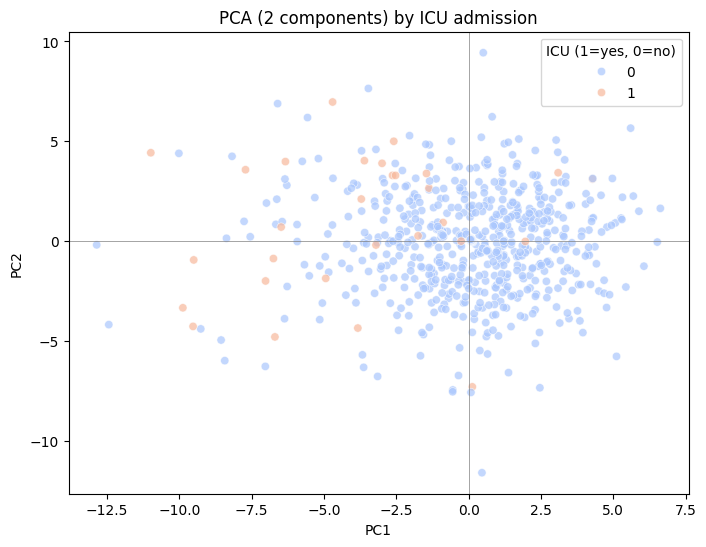

In [12]:
# PCA (2 components) colored by ICU admission
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_final.index)
pca_df["ICU"] = icu_labels.values

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="ICU", palette="coolwarm", alpha=0.7)
plt.title("PCA (2 components) by ICU admission")
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.legend(title="ICU (1=yes, 0=no)")
plt.show()



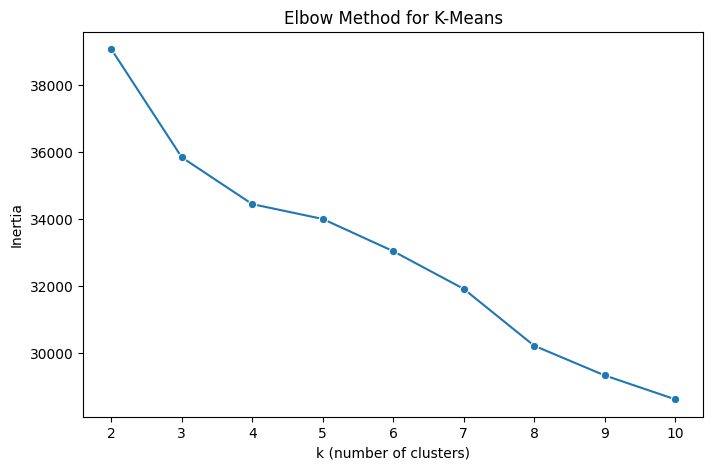

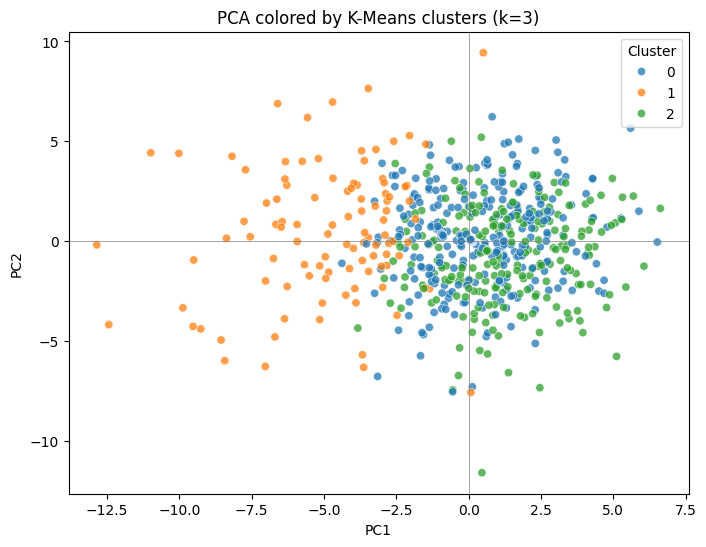

In [13]:
# Elbow method for K-Means and clustering visualization
k_range = range(2, 11)
inertias = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
sns.lineplot(x=list(k_range), y=inertias, marker="o")
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.xticks(list(k_range))
plt.show()

# Choose k after inspecting the elbow; adjust if needed
chosen_k = 3
kmeans = KMeans(n_clusters=chosen_k, random_state=42, n_init="auto")
clusters = kmeans.fit_predict(X)

pca_df["cluster"] = clusters

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.75)
plt.title(f"PCA colored by K-Means clusters (k={chosen_k})")
plt.axhline(0, color="gray", linewidth=0.5)
plt.axvline(0, color="gray", linewidth=0.5)
plt.legend(title="Cluster")
plt.show()



TypeError: Image data of dtype object cannot be converted to float

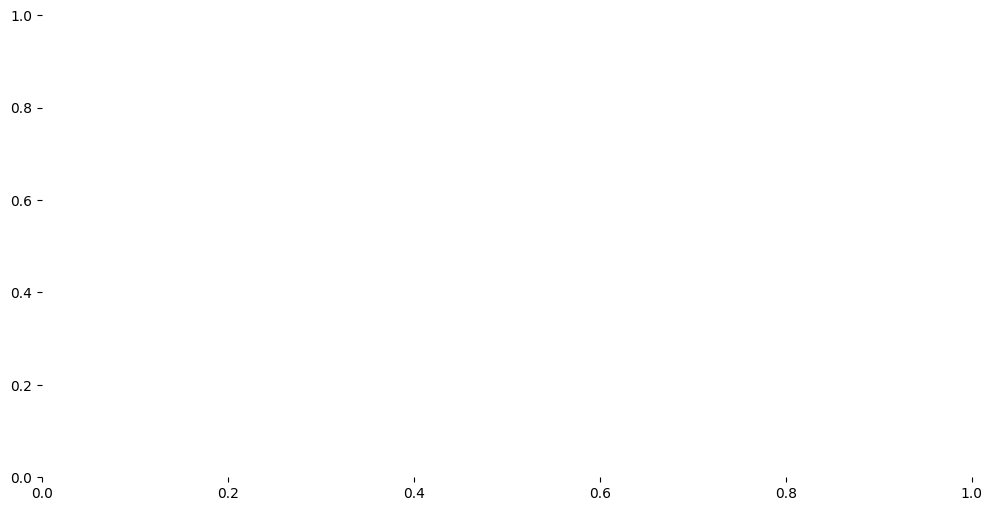

In [ ]:
# Cluster-level heatmap (standardized feature means)
cluster_df = pd.DataFrame(X, columns=features_for_model, index=df_final.index)
cluster_df["cluster"] = clusters
cluster_means = cluster_df.groupby("cluster").mean(numeric_only=True).astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, cmap="vlag", center=0, annot=False, cbar_kws={"label": "Mean (z-score / encoded values)"})
plt.title("Cluster characteristic heatmap (standardized + encoded features)")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

